**Import Dependencies**

In [ ]:
import tensorflow as tf
import keras
from keras import layers
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

**Import Keras API Key**

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fatemehfarsijani","key":"a701917d41fdea2e19437c49df521821"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


**Download Database From Keras**

In [3]:
!kaggle datasets download -d mikoajfish99/lions-or-cheetahs-image-classification

Dataset URL: https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification
License(s): Attribution 4.0 International (CC BY 4.0)
 80% 57.0M/71.3M [00:00<00:00, 77.5MB/s]
100% 71.3M/71.3M [00:00<00:00, 91.1MB/s]


In [4]:
!unzip -qq lions-or-cheetahs-image-classification.zip

**Load Data**

In [16]:
data_dir="/content/images"
data=tf.keras.utils.image_dataset_from_directory(data_dir,labels="inferred",image_size=(227,227))

Found 200 files belonging to 2 classes.


**see how the index goes of classess**

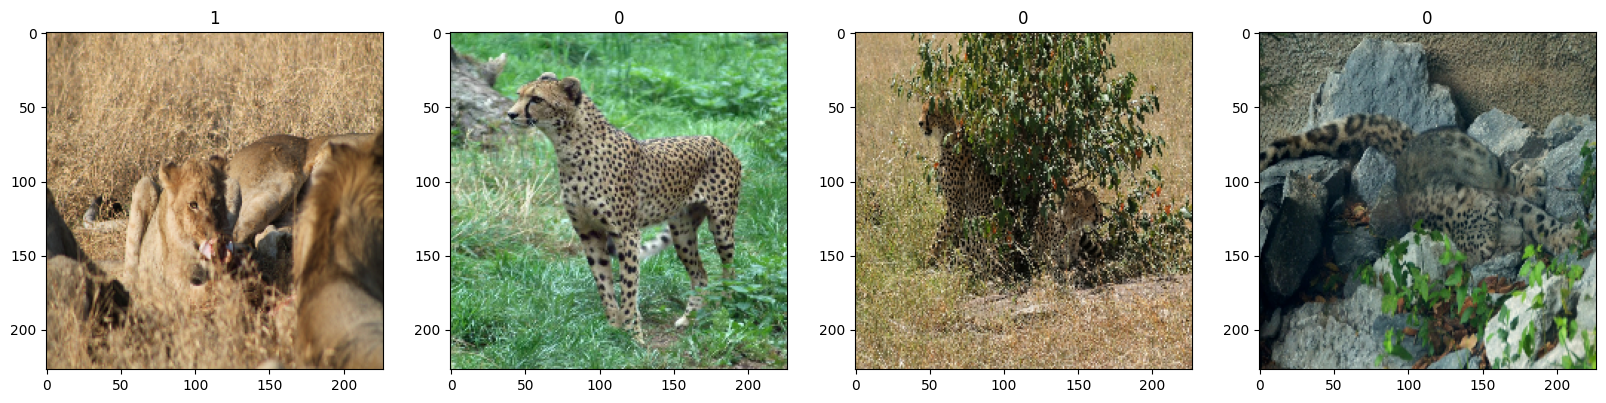

In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

**Split Data to Train and Test and Validation**

In [17]:
train_size=int(len(data)*.5)
val_size=int(len(data)*.4)
test_size=int(len(data)*.2)
train=data.take(train_size)
validation=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

**turn  train and validation and test images and labels to numpy**

In [18]:
def to_numpy(dataset):
    images = []
    labels = []
    for image, label in dataset.unbatch():
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

train_images, train_labels = to_numpy(train)
val_images, val_labels = to_numpy(validation)
test_images, test_labels = to_numpy(test)

In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [ ]:
for data_batch, labels_batch in train:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


### The max-pooling operation

**An incorrectly structured convnet missing its max-pooling layers**

In [ ]:
inputs = keras.Input(shape=(227, 227, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_no_max_pool.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 225, 225, 32)      896       
                                                                 
 conv2d_7 (Conv2D)           (None, 223, 223, 64)      18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 221, 221, 128)     73856     
                                                                 
 flatten_2 (Flatten)         (None, 6251648)           0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6251649   
                                                                 
Total params: 6344897 (24.20 MB)
Trainable params: 6344897 

In [ ]:
model_no_max_pool.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model_no_max_pool.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=callbacks)

Epoch 1/10
3/3 [==============================] - 84s 30s/step - loss: 58090.7305 - accuracy: 0.5000 - val_loss: 4543.5605 - val_accuracy: 0.5469
Epoch 2/10
3/3 [==============================] - 84s 29s/step - loss: 3230.4602 - accuracy: 0.4896 - val_loss: 3132.0540 - val_accuracy: 0.4688
Epoch 3/10
3/3 [==============================] - 79s 29s/step - loss: 1590.1089 - accuracy: 0.4688 - val_loss: 566.2440 - val_accuracy: 0.5469
Epoch 4/10
3/3 [==============================] - 81s 30s/step - loss: 907.2654 - accuracy: 0.4896 - val_loss: 447.0775 - val_accuracy: 0.5156
Epoch 5/10
3/3 [==============================] - 83s 30s/step - loss: 184.0189 - accuracy: 0.4792 - val_loss: 129.3311 - val_accuracy: 0.5781
Epoch 6/10
3/3 [==============================] - 81s 29s/step - loss: 42.8337 - accuracy: 0.5208 - val_loss: 127.9075 - val_accuracy: 0.4531
Epoch 7/10
3/3 [==============================] - 89s 33s/step - loss: 68.8999 - accuracy: 0.4479 - val_loss: 140.2814 - val_accuracy: 0.

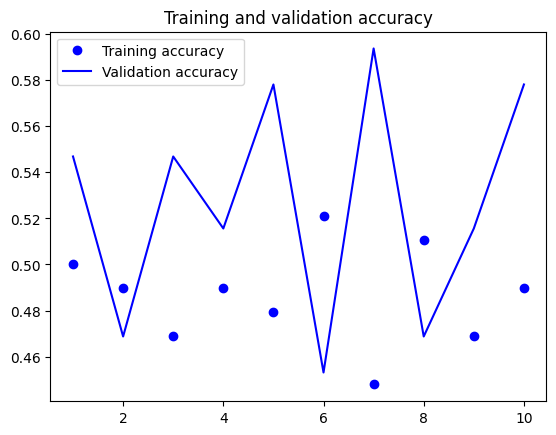

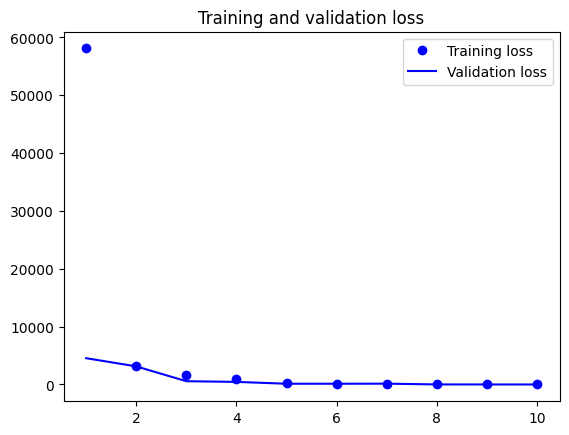

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 7s 7s/step - loss: 1.8427 - accuracy: 0.4375
Test accuracy: 0.438


**with maxpooling layers**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(227, 227, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_with_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_with_max_pool.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history1 = model.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=callbacks)

Epoch 1/10
3/3 [==============================] - 20s 6s/step - loss: 1.0803 - accuracy: 0.4583 - val_loss: 0.6929 - val_accuracy: 0.5312
Epoch 2/10
3/3 [==============================] - 23s 8s/step - loss: 0.6938 - accuracy: 0.5000 - val_loss: 0.7014 - val_accuracy: 0.4375
Epoch 3/10
3/3 [==============================] - 18s 6s/step - loss: 0.6866 - accuracy: 0.5208 - val_loss: 0.6972 - val_accuracy: 0.4375
Epoch 4/10
3/3 [==============================] - 16s 6s/step - loss: 0.6946 - accuracy: 0.4688 - val_loss: 0.6914 - val_accuracy: 0.5000
Epoch 5/10
3/3 [==============================] - 17s 6s/step - loss: 0.6892 - accuracy: 0.5104 - val_loss: 0.6891 - val_accuracy: 0.5156
Epoch 6/10
3/3 [==============================] - 17s 6s/step - loss: 0.6942 - accuracy: 0.5104 - val_loss: 0.6866 - val_accuracy: 0.5312
Epoch 7/10
3/3 [==============================] - 16s 6s/step - loss: 0.6914 - accuracy: 0.5312 - val_loss: 0.7001 - val_accuracy: 0.3906
Epoch 8/10
3/3 [==================

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 227, 227, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 225, 225, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_10 (Conv2D)          (None, 110, 110, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                      

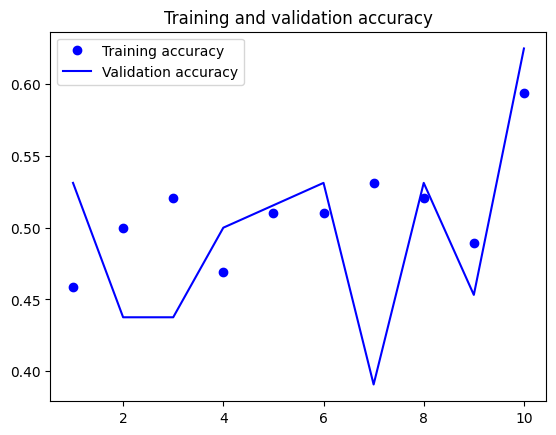

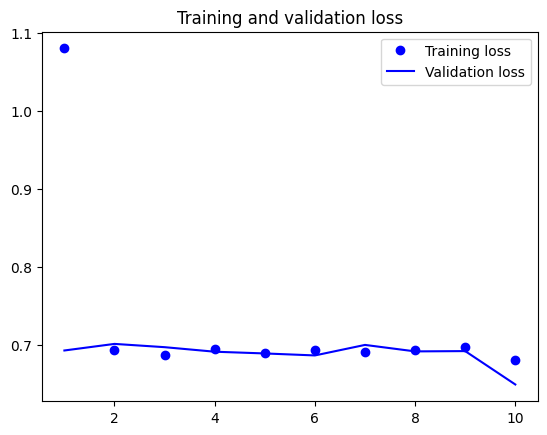

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history1.history["val_accuracy"]
loss = history1.history["loss"]
val_loss = history1.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 3s 3s/step - loss: 0.6619 - accuracy: 0.5938
Test accuracy: 0.594


**Use AveragePooling**

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(227, 227, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.AveragePooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.AveragePooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.AveragePooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.AveragePooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_with_avg_pool = keras.Model(inputs=inputs, outputs=outputs)


In [22]:
model_with_avg_pool.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [23]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model_with_avg_pool.fit(
    train,
    epochs=10,
    validation_data=validation,
    callbacks=callbacks)

Epoch 1/10
3/3 [==============================] - 21s 7s/step - loss: 0.7840 - accuracy: 0.5417 - val_loss: 0.6963 - val_accuracy: 0.4531
Epoch 2/10
3/3 [==============================] - 22s 9s/step - loss: 0.6940 - accuracy: 0.5104 - val_loss: 0.6848 - val_accuracy: 0.5469
Epoch 3/10
3/3 [==============================] - 18s 7s/step - loss: 0.7623 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 4/10
3/3 [==============================] - 18s 6s/step - loss: 0.6936 - accuracy: 0.4583 - val_loss: 0.6939 - val_accuracy: 0.4219
Epoch 5/10
3/3 [==============================] - 19s 6s/step - loss: 0.6937 - accuracy: 0.5312 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 6/10
3/3 [==============================] - 23s 9s/step - loss: 0.6929 - accuracy: 0.5208 - val_loss: 0.6939 - val_accuracy: 0.4375
Epoch 7/10
3/3 [==============================] - 18s 7s/step - loss: 0.6939 - accuracy: 0.4479 - val_loss: 0.6934 - val_accuracy: 0.4375
Epoch 8/10
3/3 [==================

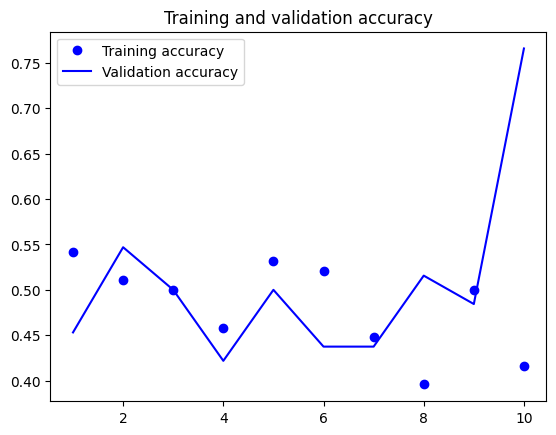

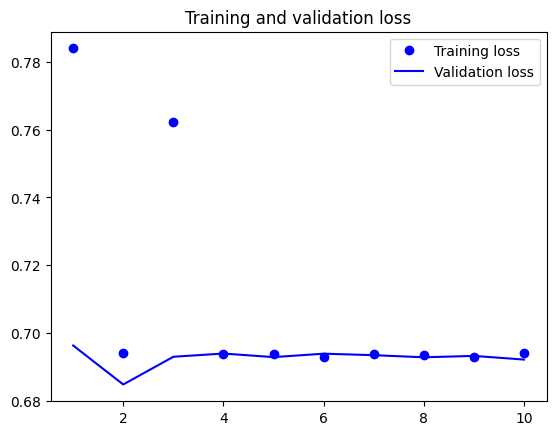

In [24]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [25]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 3s 3s/step - loss: 0.7225 - accuracy: 0.4062
Test accuracy: 0.406


**Using data augmentation and Dropout**

**Define a data augmentation stage to add to an image model**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

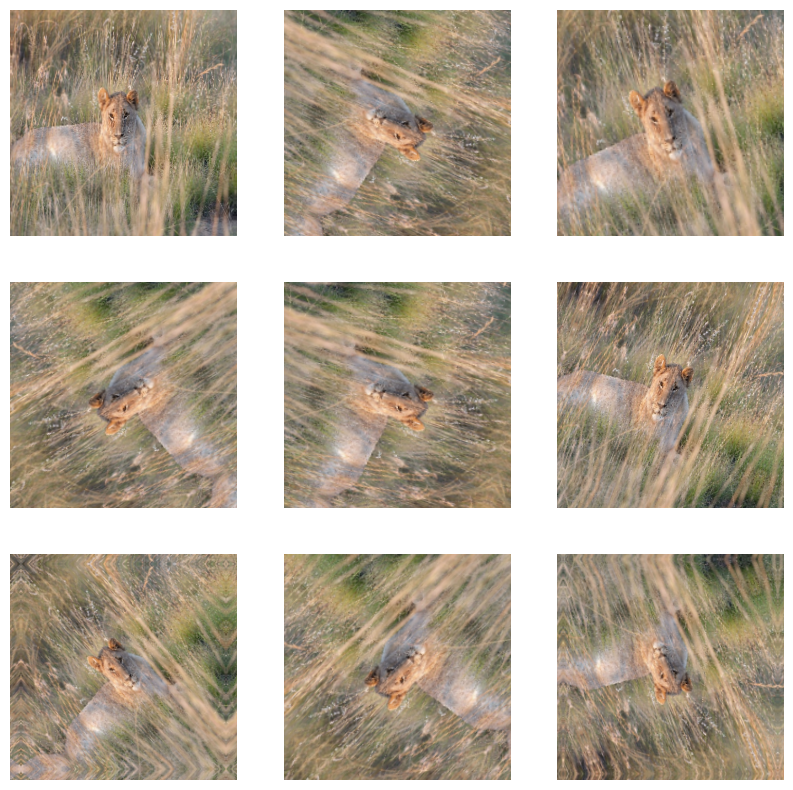

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(227, 227, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history2 = model.fit(
    train,
    epochs=100,
    validation_data=validation,
    callbacks=callbacks)

Epoch 1/100
3/3 [==============================] - 19s 6s/step - loss: 0.9555 - accuracy: 0.4688 - val_loss: 0.6947 - val_accuracy: 0.4531
Epoch 2/100
3/3 [==============================] - 19s 6s/step - loss: 0.7091 - accuracy: 0.4583 - val_loss: 0.6941 - val_accuracy: 0.4844
Epoch 3/100
3/3 [==============================] - 17s 6s/step - loss: 0.6925 - accuracy: 0.5104 - val_loss: 0.6845 - val_accuracy: 0.5781
Epoch 4/100
3/3 [==============================] - 19s 6s/step - loss: 0.7127 - accuracy: 0.4583 - val_loss: 0.6932 - val_accuracy: 0.4844
Epoch 5/100
3/3 [==============================] - 17s 6s/step - loss: 0.6932 - accuracy: 0.4792 - val_loss: 0.6913 - val_accuracy: 0.5625
Epoch 6/100
3/3 [==============================] - 19s 6s/step - loss: 0.6930 - accuracy: 0.5104 - val_loss: 0.6936 - val_accuracy: 0.4531
Epoch 7/100
3/3 [==============================] - 17s 6s/step - loss: 0.6896 - accuracy: 0.5417 - val_loss: 0.6899 - val_accuracy: 0.5312
Epoch 8/100
3/3 [==========

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 3s 3s/step - loss: 0.4557 - accuracy: 0.8438
Test accuracy: 0.844


### Feature extraction with a pretrained Vgg16 model

**Instantiating the VGG16 convolutional base**

In [ ]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [ ]:
data_dir="/content/images"
data=tf.keras.utils.image_dataset_from_directory(data_dir,labels="inferred",image_size=(180,180))
train_size=int(len(data)*.5)
val_size=int(len(data)*.4)
test_size=int(len(data)*.2)
train=data.take(train_size)
validation=data.skip(train_size).take(val_size)
test=data.skip(train_size+val_size).take(test_size)

Found 200 files belonging to 2 classes.


**Extracting the VGG16 features and corresponding labels**

In [ ]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train)
val_features, val_labels =  get_features_and_labels(validation)
test_features, test_labels =  get_features_and_labels(test)

1/1 [==============================] - 13s 13s/step


In [ ]:
train_features.shape

(96, 5, 5, 512)

**Defining and training the densely connected classifier**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
3/3 [==============================] - 1s 267ms/step - loss: 21.8734 - accuracy: 0.6979 - val_loss: 84.2346 - val_accuracy: 0.6406
Epoch 2/20
3/3 [==============================] - 0s 116ms/step - loss: 48.6430 - accuracy: 0.7708 - val_loss: 18.7382 - val_accuracy: 0.9062
Epoch 3/20
3/3 [==============================] - 0s 107ms/step - loss: 19.8186 - accuracy: 0.9479 - val_loss: 8.3360 - val_accuracy: 0.9219
Epoch 4/20
3/3 [==============================] - 0s 107ms/step - loss: 1.4047e-04 - accuracy: 1.0000 - val_loss: 8.3205 - val_accuracy: 0.9219
Epoch 5/20
3/3 [==============================] - 0s 57ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 8.3205 - val_accuracy: 0.9219
Epoch 6/20
3/3 [==============================] - 0s 60ms/step - loss: 0.0621 - accuracy: 0.9896 - val_loss: 14.5201 - val_accuracy: 0.8594
Epoch 7/20
3/3 [==============================] - 0s 56ms/step - loss: 2.6542 - accuracy: 0.9688 - val_loss: 11.5799 - val_accuracy: 0.8906
Epoch 8/

**Plotting the results**

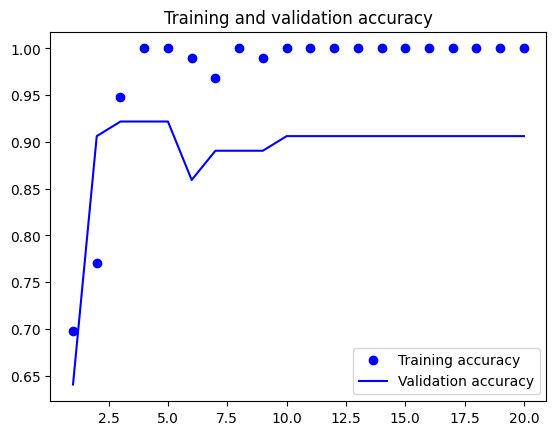

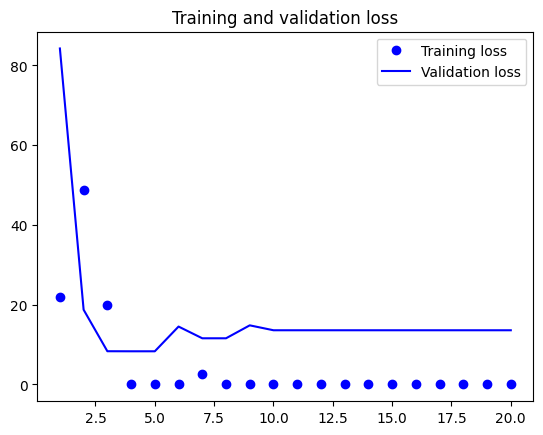

In [ ]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model(
    "feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 0s 213ms/step - loss: 0.5569 - accuracy: 0.9688
Test accuracy: 0.969


pretarin model **Vgg16**

**use finetune 4 last layer and train fully connected**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load data from directory
data_dir = "/content/images"
batch_size = 32
image_size = (224, 224)

# Load and split data
data = tf.keras.utils.image_dataset_from_directory(data_dir, labels="inferred", image_size=image_size, batch_size=batch_size)
train_size = int(0.5 * len(data))
val_size = int(0.3 * len(data))
test_size = int(0.2 * len(data))

train_data = data.take(train_size)
remaining_data = data.skip(train_size)
val_data = remaining_data.take(val_size)
test_data = remaining_data.skip(val_size).take(test_size)

# Prefetch data for performance improvement
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Load VGG16 model with pretrained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Unfreeze some top layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Continue training (fine-tuning)
history5=model.fit(train_data, validation_data=val_data, epochs=10)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc}')


Found 200 files belonging to 2 classes.
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
3/3 [==============================] - 99s 39s/step - loss: 16.3711 - accuracy: 0.6354 - val_loss: 10.8813 - val_accuracy: 0.8281
Epoch 2/10
3/3 [==============================] - 98s 38s/step - loss: 9.4539 - accuracy: 0.8125 - val_loss: 10.6910 - val_accuracy: 0.8906
Epoch 3/10
3/3 [==============================] - 100s 40s/step - loss: 2.7915 - accuracy: 0.9479 - val_loss: 0.4733 - val_accuracy: 0.9531
Epoch 4/10
3/3 [==============================] - 98s 39s/step - loss: 2.6944 - accuracy: 0.9062 - val_loss: 0.9836 - val_accuracy: 0.9531
Epoch 5/10
3/3 [==============================] - 99s 39s/step - loss: 0.6842 - accuracy: 0.9688 - val_loss: 0.0127 - val_accuracy: 0.9844
Epoch 6/10
3/3 [==============================] - 98s 39s/step - loss: 0.2285 - accuracy: 0.9896 - val_loss: 2.6153 - val_accuracy: 0.9531
Epoch 7/10
3/3 [==============================] - 98s 39s

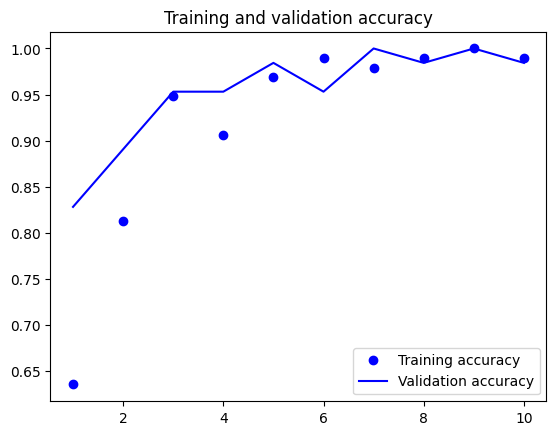

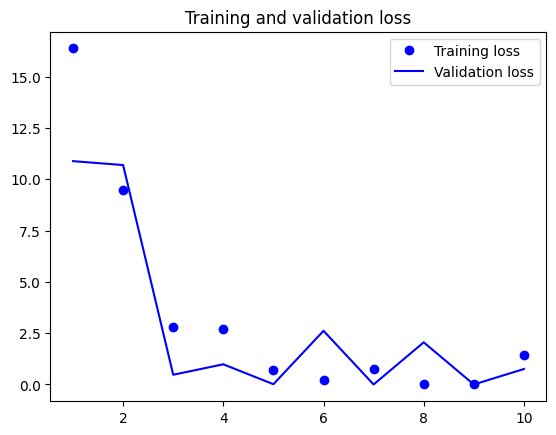

In [ ]:
import matplotlib.pyplot as plt
acc = history5.history["accuracy"]
val_acc = history5.history["val_accuracy"]
loss = history5.history["loss"]
val_loss = history5.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Confusion matrix**

1/1 [==============================] - 20s 20s/step


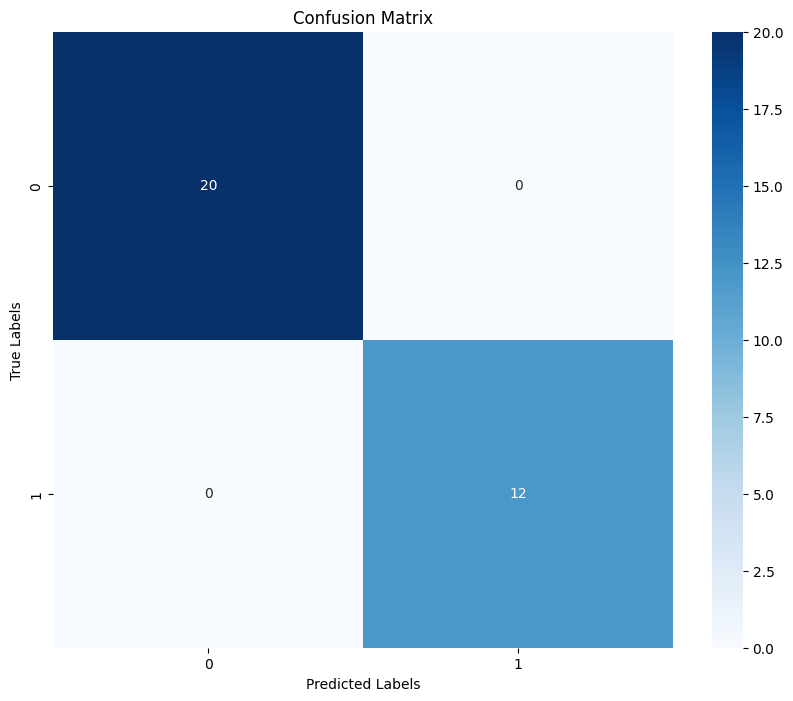

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        12

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [ ]:
true_labels = []
predicted_labels = []

for batch in test_data:
    images, labels = batch
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_labels.extend(np.round(predictions).astype(int).flatten())

true_labels = np.array(true_labels).astype(int).flatten()
predicted_labels = np.array(predicted_labels).astype(int).flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

**Adding a data augmentation stage and a classifier to the convolutional base**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

# Load data from directory
data_dir = "/content/images"
batch_size = 32
image_size = (224, 224)

# Load and split data
data = tf.keras.utils.image_dataset_from_directory(data_dir, labels="inferred", image_size=image_size, batch_size=batch_size)
train_size = int(0.5 * len(data))
val_size = int(0.3 * len(data))
test_size = int(0.2 * len(data))

train_data = data.take(train_size)
remaining_data = data.skip(train_size)
val_data = remaining_data.take(val_size)
test_data = remaining_data.skip(val_size).take(test_size)

# Prefetch data for performance improvement
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

# Load VGG16 model with pretrained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add data augmentation and custom layers on top of the base model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history6=model.fit(train_data, validation_data=val_data, epochs=10)


Found 200 files belonging to 2 classes.
Epoch 1/10
3/3 [==============================] - 103s 40s/step - loss: 31.7730 - accuracy: 0.4896 - val_loss: 36.8327 - val_accuracy: 0.5312
Epoch 2/10
3/3 [==============================] - 99s 39s/step - loss: 13.1800 - accuracy: 0.7292 - val_loss: 17.3034 - val_accuracy: 0.6719
Epoch 3/10
3/3 [==============================] - 99s 39s/step - loss: 9.3023 - accuracy: 0.7396 - val_loss: 2.7683 - val_accuracy: 0.8750
Epoch 4/10
3/3 [==============================] - 99s 39s/step - loss: 3.4710 - accuracy: 0.7500 - val_loss: 5.8680 - val_accuracy: 0.7188
Epoch 5/10
3/3 [==============================] - 99s 38s/step - loss: 3.3862 - accuracy: 0.6771 - val_loss: 1.6331 - val_accuracy: 0.7969
Epoch 6/10
3/3 [==============================] - 99s 39s/step - loss: 1.1204 - accuracy: 0.8438 - val_loss: 0.9069 - val_accuracy: 0.8594
Epoch 7/10
3/3 [==============================] - 98s 39s/step - loss: 0.7963 - accuracy: 0.8750 - val_loss: 0.9924 - val

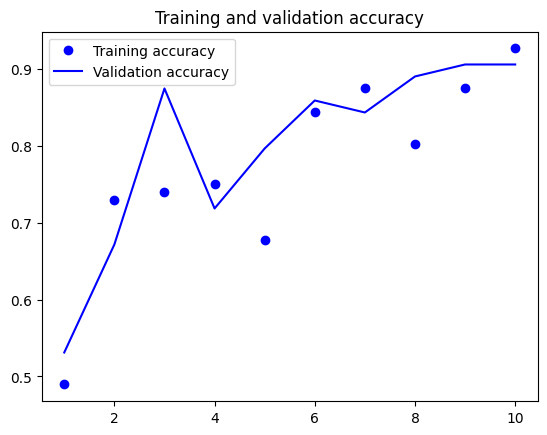

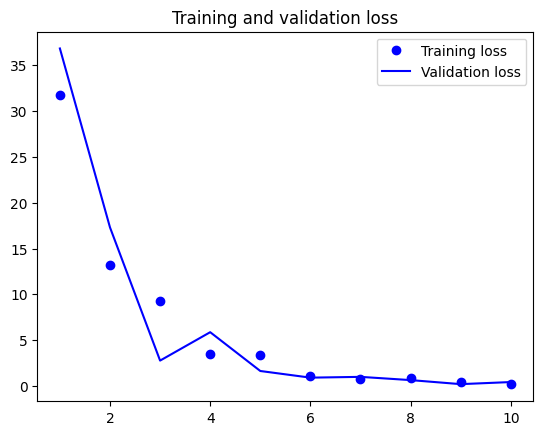

In [ ]:
import matplotlib.pyplot as plt
acc = history6.history["accuracy"]
val_acc = history6.history["val_accuracy"]
loss = history6.history["loss"]
val_loss = history6.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc}')

1/1 [==============================] - 57s 57s/step - loss: 0.1626 - accuracy: 0.9375
Test accuracy: 0.9375


**confusion matrix**

1/1 [==============================] - 19s 19s/step


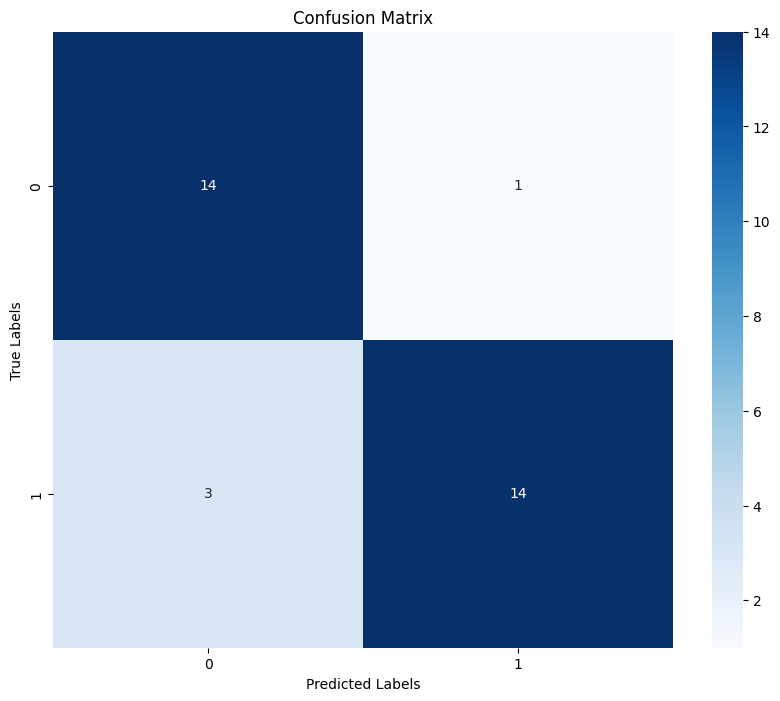

Accuracy: 0.875
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        15
           1       0.93      0.82      0.87        17

    accuracy                           0.88        32
   macro avg       0.88      0.88      0.87        32
weighted avg       0.88      0.88      0.87        32



In [ ]:
true_labels = []
predicted_labels = []

for batch in test_data:
    images, labels = batch
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_labels.extend(np.round(predictions).astype(int).flatten())

true_labels = np.array(true_labels).astype(int).flatten()
predicted_labels = np.array(predicted_labels).astype(int).flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Try using The pretrain **Resnet 50**

**feature extraction with pretrain convs and train fully connected**

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# بارگذاری مدل پیش‌آموزش‌دیده ResNet50 بدون لایه‌های بالایی
conv_base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

# آماده‌سازی داده‌ها
data_dir = "/content/images"
data = tf.keras.utils.image_dataset_from_directory(data_dir, labels="inferred", image_size=(180, 180))

train_size = int(len(data) * 0.5)
val_size = int(len(data) * 0.4)
test_size = int(len(data) * 0.2)

train = data.take(train_size)
validation = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# تابع برای استخراج ویژگی‌ها و برچسب‌ها
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = tf.keras.applications.resnet50.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

# استخراج ویژگی‌ها و برچسب‌ها
train_features, train_labels = get_features_and_labels(train)
val_features, val_labels = get_features_and_labels(validation)
test_features, test_labels = get_features_and_labels(test)

# ساخت مدل جدید
inputs = tf.keras.Input(shape=(6, 6, 2048))  # ResNet50 خروجی لایه آخر
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# تعریف callbacks برای ذخیره بهترین مدل
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction_resnet.keras",
      save_best_only=True,
      monitor="val_loss")
]

# آموزش مدل
history7= model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

# ارزیابی مدل
test_loss, test_accuracy = model.evaluate(test_features, test_labels)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Found 200 files belonging to 2 classes.
1/1 [==============================] - 7s 7s/step
Epoch 1/20
3/3 [==============================] - 2s 796ms/step - loss: 62.1134 - accuracy: 0.5417 - val_loss: 1.6810 - val_accuracy: 0.8750
Epoch 2/20
3/3 [==============================] - 1s 364ms/step - loss: 5.2755 - accuracy: 0.8646 - val_loss: 7.7305 - val_accuracy: 0.8281
Epoch 3/20
3/3 [==============================] - 1s 349ms/step - loss: 2.3230 - accuracy: 0.9167 - val_loss: 1.8359 - val_accuracy: 0.9062
Epoch 4/20
3/3 [==============================] - 1s 381ms/step - loss: 1.0868 - accuracy: 0.9688 - val_loss: 2.2415 - val_accuracy: 0.9375
Epoch 5/20
3/3 [==============================] - 1s 383ms/step - loss: 0.8166 - accuracy: 0.9688 - val_loss: 2.7217 - val_accuracy: 0.9062
Epoch 6/20
3/3 [==============================] - 2s 607ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 2.1871 - val_accuracy: 0.9062
Epoch 7/20
3/3 [==============================] - 2s 647ms/step - los

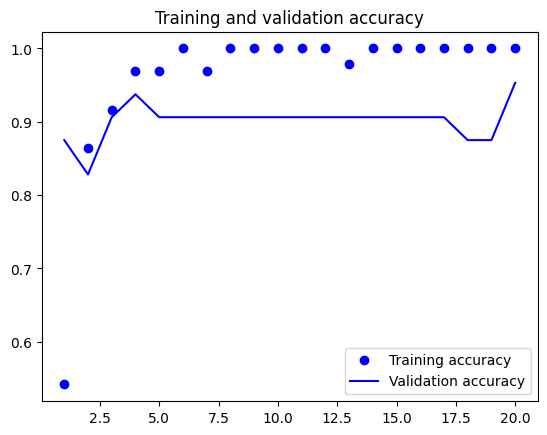

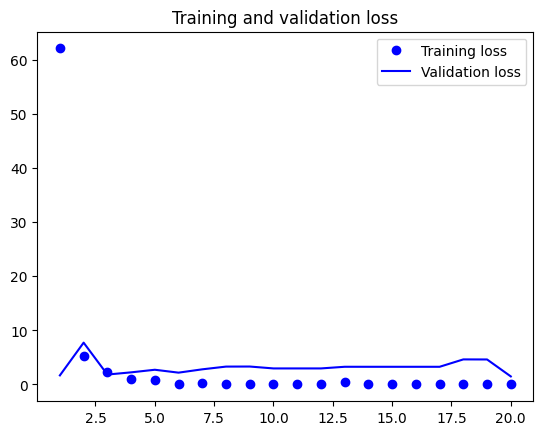

In [3]:
import matplotlib.pyplot as plt
acc = history7.history["accuracy"]
val_acc = history7.history["val_accuracy"]
loss = history7.history["loss"]
val_loss = history7.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Use finetune 4 last layer and train Fully connected**

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load data from directory
data_dir = "/content/images"
batch_size = 32
image_size = (224, 224)

# Load and split data
data = tf.keras.utils.image_dataset_from_directory(data_dir, labels="inferred", image_size=image_size, batch_size=batch_size)
train_size = int(0.5 * len(data))
val_size = int(0.3 * len(data))
test_size = int(0.2 * len(data))

train_data = data.take(train_size)
remaining_data = data.skip(train_size)
val_data = remaining_data.take(val_size)
test_data = remaining_data.skip(val_size).take(test_size)

# Prefetch data for performance improvement
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Load ResNet50 model with pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Unfreeze some top layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Continue training (fine-tuning)
history = model.fit(train_data, validation_data=val_data, epochs=10)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc}')


Found 200 files belonging to 2 classes.
Epoch 1/10
3/3 [==============================] - 42s 15s/step - loss: 32.3116 - accuracy: 0.6354 - val_loss: 17.1707 - val_accuracy: 0.6250
Epoch 2/10
3/3 [==============================] - 45s 17s/step - loss: 9.2250 - accuracy: 0.7812 - val_loss: 3.4047 - val_accuracy: 0.8594
Epoch 3/10
3/3 [==============================] - 38s 14s/step - loss: 4.2794 - accuracy: 0.8750 - val_loss: 1.6222 - val_accuracy: 0.9531
Epoch 4/10
3/3 [==============================] - 45s 18s/step - loss: 1.7351 - accuracy: 0.9271 - val_loss: 0.1878 - val_accuracy: 0.9844
Epoch 5/10
3/3 [==============================] - 46s 18s/step - loss: 1.6529 - accuracy: 0.9062 - val_loss: 1.5655e-06 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 43s 17s/step - loss: 0.0179 - accuracy: 0.9896 - val_loss: 1.1486 - val_accuracy: 0.9531
Epoch 7/10
3/3 [==============================] - 40s 15s/step - loss: 0.6939 - accuracy: 0.9688 - val_loss: 3.6629e-12 

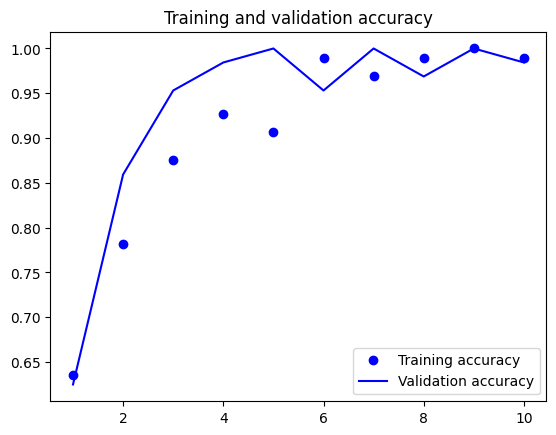

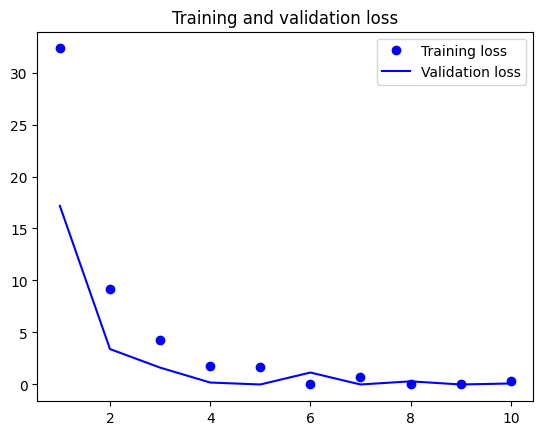

In [8]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**confusion matrix**

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


1/1 [==============================] - 6s 6s/step


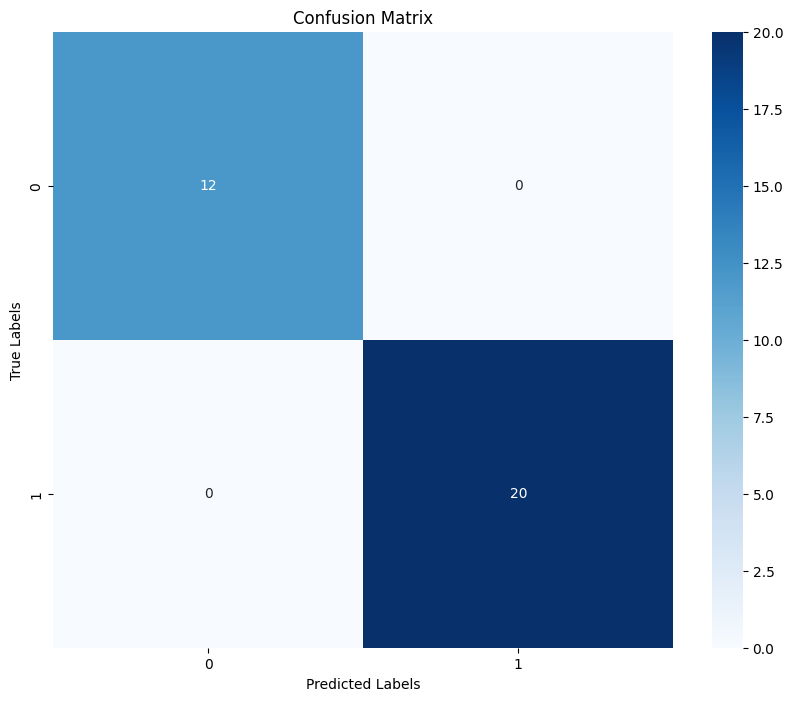

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        20

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [11]:
true_labels = []
predicted_labels = []

for batch in test_data:
    images, labels = batch
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_labels.extend(np.round(predictions).astype(int).flatten())

true_labels = np.array(true_labels).astype(int).flatten()
predicted_labels = np.array(predicted_labels).astype(int).flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

**Adding a data augmentation stage and a classifier to the convolutional base**

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

# Load data from directory
data_dir = "/content/images"
batch_size = 32
image_size = (224, 224)

# Load and split data
data = tf.keras.utils.image_dataset_from_directory(data_dir, labels="inferred", image_size=image_size, batch_size=batch_size)
train_size = int(0.5 * len(data))
val_size = int(0.3 * len(data))
test_size = int(0.2 * len(data))

train_data = data.take(train_size)
remaining_data = data.skip(train_size)
val_data = remaining_data.take(val_size)
test_data = remaining_data.skip(val_size).take(test_size)

# Prefetch data for performance improvement
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Data augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
])

# Load ResNet50 model with pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add data augmentation and custom layers on top of the base model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=10)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_data)
print(f'Test accuracy: {test_acc}')


Found 200 files belonging to 2 classes.
Epoch 1/10
3/3 [==============================] - 53s 19s/step - loss: 26.5249 - accuracy: 0.4479 - val_loss: 5.4793 - val_accuracy: 0.6562
Epoch 2/10
3/3 [==============================] - 43s 16s/step - loss: 4.9806 - accuracy: 0.6875 - val_loss: 7.5619 - val_accuracy: 0.7031
Epoch 3/10
3/3 [==============================] - 38s 15s/step - loss: 2.3131 - accuracy: 0.8229 - val_loss: 2.1092 - val_accuracy: 0.8438
Epoch 4/10
3/3 [==============================] - 39s 14s/step - loss: 1.4424 - accuracy: 0.8750 - val_loss: 1.3112 - val_accuracy: 0.9062
Epoch 5/10
3/3 [==============================] - 39s 15s/step - loss: 1.2968 - accuracy: 0.8438 - val_loss: 0.6460 - val_accuracy: 0.9688
Epoch 6/10
3/3 [==============================] - 38s 15s/step - loss: 1.1426 - accuracy: 0.8958 - val_loss: 1.4829 - val_accuracy: 0.9062
Epoch 7/10
3/3 [==============================] - 47s 18s/step - loss: 1.2341 - accuracy: 0.8958 - val_loss: 0.1674 - val_acc

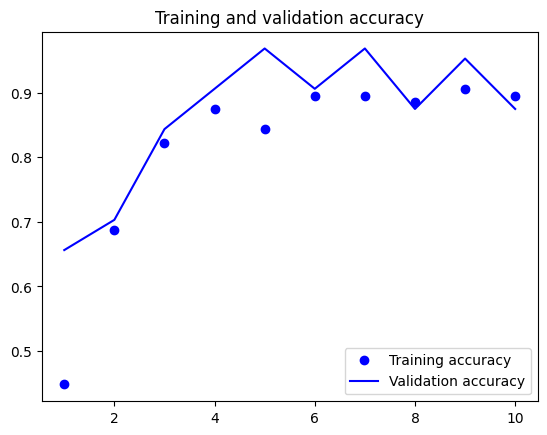

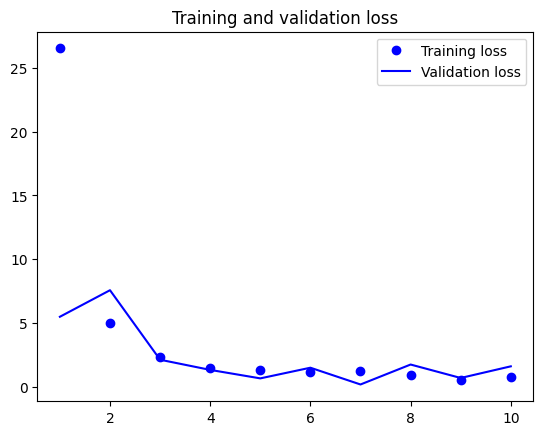

In [14]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**confusion matrix**

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

1/1 [==============================] - 7s 7s/step


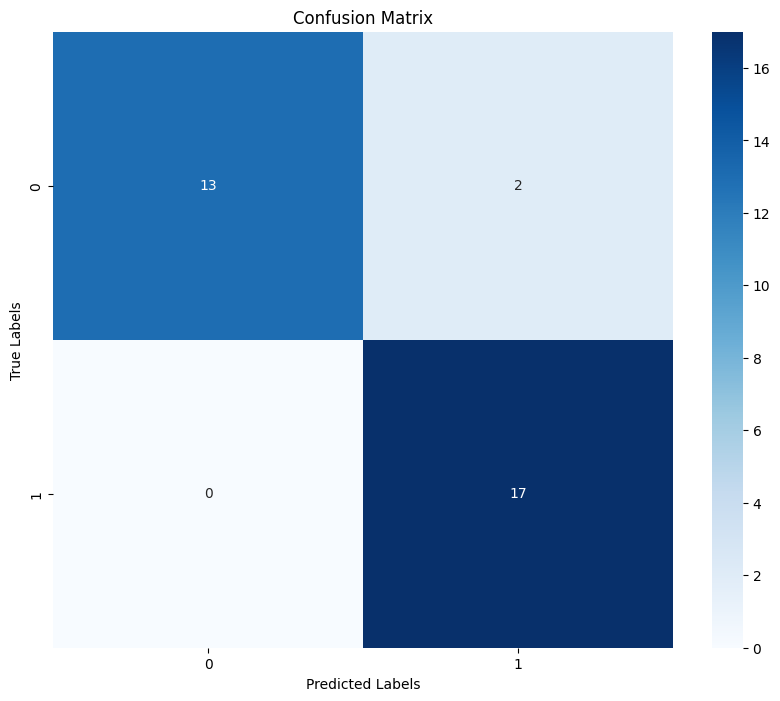

Accuracy: 0.9375
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        15
           1       0.89      1.00      0.94        17

    accuracy                           0.94        32
   macro avg       0.95      0.93      0.94        32
weighted avg       0.94      0.94      0.94        32



In [15]:
true_labels = []
predicted_labels = []

for batch in test_data:
    images, labels = batch
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_labels.extend(np.round(predictions).astype(int).flatten())

true_labels = np.array(true_labels).astype(int).flatten()
predicted_labels = np.array(predicted_labels).astype(int).flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)